## Validation Predictions and Model Interpretation

* <a href='#Train the Model'>Train the Best Model and Predict Validation Data</a>
* <a href='#Model and Prediction Explanations'>Model and Prediction Explanations</a>
    * <a href='#Use a simplified model as example for explanation'>Use a simplified model as example for explanation</a>
    * <a href='#Plot tree'>Plot the decision path in one tree</a>
    * <a href='#Important Features'>Important Features</a>
    * <a href='#Validation Prediction Results and Explanation'>Validation Prediction Results and Explanation</a>

In [1]:
#TODO: make sure to use conda install for the following packages!
#conda install pydot
#conda install graphviz


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, brier_score_loss
from collections import Counter
from modules import nlp,preprocess,models,text_augmentation
from sklearn.ensemble import RandomForestClassifier
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer,PorterStemmer
import re

# TODO: setting for training model
upload_data = 'data/'
model_collection_name = 'model'
tfidf_features_num = 5000
oversample_size = 1 
training_test_size = 0.3
perf_path = 'tmp_model_perf/'
valid_path = 'temp_file/validationExplanation/'
random_seed =116  
unseen_data_size=0.1 
number_of_synonym =3

Using TensorFlow backend.


### Train the Model with Best Parameters
<a id='Train the Model'></a>
This step is to :
1. train a random forest with all available data after model selection and evaluation
1. get prediction results for the validation dataset provided by GSA.

In [2]:
training_data = pd.read_csv(upload_data+'AI_ML_Challenge_Training_Data_Set_1_v1.txt',sep=',')
appendix= pd.read_excel(upload_data+'Clauses_From_Appendix.xlsx')
training_data = pd.concat([training_data,appendix],axis=0).reset_index(drop=True)
training_data['Clause ID'] = training_data['Clause ID'].fillna(training_data[training_data['Clause ID'].isna()]['Clause ID'].index.to_series())

print('Training data size: ',training_data.shape)
training_data['Classification'] = training_data['Classification'].astype(float).astype(str)
# drop nan values
training_data.drop(training_data[training_data['Classification'] == 'nan'].index, inplace=True)
# preprocess data
train_df = nlp.nlp_cleaning_pre(training_data, colname='PRE_CLEAN_TEXT', textcol='Clause Text')


training_x = train_df.loc[:,train_df.columns!='Classification']
training_y = train_df['Classification']


#text augmentation
train_df,aug_df = text_augmentation.get_augmented_df(base_df=train_df,common_cols = ['Clause ID', 'Classification', 'PRE_CLEAN_TEXT'],number_of_synonym = number_of_synonym)
#Counter(train_df['Classification'])


#save transformer
tfidf = TfidfVectorizer(max_features=tfidf_features_num)

save_vectorizer = tfidf.fit(train_df['PRE_CLEAN_TEXT'])
train_features = save_vectorizer.transform(train_df['PRE_CLEAN_TEXT'])
train_target = train_df['Classification']
#save_vectorizer.get_feature_names()

#train model
print('Data ready to fit into models.')

prep = preprocess.Preprocess(train_features, train_target)

# oversample
X_sm, y_sm = prep.resampling(oversample_ratio=oversample_size,
                             minority_num=train_df['Classification'].value_counts()[1],
                             majority_num=train_df['Classification'].value_counts()[0],
                             minority_label=train_df['Classification'].value_counts().index[1],
                             majority_label=train_df['Classification'].value_counts().index[0])



Counter( y_sm)

model_class = models.ML_classifiers()

clf_names = list(model_class.classifiers.keys())
print('Pre-determined models:',clf_names)
X_train, y_train = X_sm.toarray(), y_sm




X_test_df =pd.read_csv(upload_data+'AI_ML_Challenge_Validation_Data_Set_v1.txt',sep=',') 
print('Validation data size: ',X_test_df.shape)
# preprocess data
X_test = nlp.nlp_cleaning_pre(X_test_df, colname='PRE_CLEAN_TEXT', textcol='Clause Text')
X_test = save_vectorizer.transform(X_test['PRE_CLEAN_TEXT']).toarray()




clf = clf_names[0]
clf_model,clf_params = model_class.build_clf(clf)
#clf_model = GridSearchCV(clf_model, clf_params,cv=5)
clf_model.set_params(**clf_params)
best_model = clf_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:,0]

print('Finish initial training.')
#print('best parameter',best_model.best_params_)



Training data size:  (7893, 3)
Updated NLP!
Updated NLP!
Original df shape:  (1486, 4)
Finish text augmentation: augmented df shape:  (3855, 3)
augmented_unaccepted_clauses (3855, 3)
Updated NLP!
Data ready to fit into models.
Proportion in data after resample:  Counter({'0.0': 5553, '1.0': 5553})
Pre-determined models: ['Random Forest']
Validation data size:  (1391, 2)
Updated NLP!
Finish initial training.


In [3]:
#predict validation dataset
validation_df = X_test_df.copy()
validation_df['Prediction'] = pd.Series(y_pred).astype(float).astype(int)
validation_df['Probability Acceptable'] = pd.Series(y_pred_prob).astype(float)*100
print('Prediction Finished!')


# Todo: output validation dataset to csv
#validation_df.to_csv(upload_data+'UnitedSolutions_Validation_Data_File.csv',index=False)
#validation_df = pd.read_csv(upload_data+'UnitedSolutions_Validation_Data_File.csv')

Prediction Finished!


#### Important features

In [4]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(save_vectorizer.get_feature_names(), clf_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance',ascending= False)
importances = importances.reset_index().rename(columns={'index':'Feature name'})
importances.to_csv(valid_path+'important_features.csv',index=False)



importances.head(20)

,Feature name,Gini-importance
0,term,0.015863
1,agreement,0.014225
2,company,0.010980
3,may,0.010508
4,party,0.009093
5,fee,0.007944
6,shall,0.007783
7,right,0.006825
8,use,0.006762
9,without,0.006599


<a id='Important Features'></a>

Here are top ```20 important features```. Important features tell us these words have comparably strong predictive power, which means these words are important in explaining the target variable, or contribute more to mapping the testing data to the output. A limitation of this method is that the feature importance does not provide how the predictions and features are correlated, negatively or positive.

As for in EULA case, the intuition explanation from that is these words need to be treated or written carefully in EULA files. As shown above, words such as *term, agreement, fee, without,licensee* are strong predictors, and people need to pay more attention to these words.

For your reference: ```We output the whole list of feature importance in csv from this path: \temp_file\validationExplanation\important_features.csv```

### Model and Prediction Explanations
<a id='Model and Prediction Explanations'></a>
This part is to use a simplified model to explain the reasons for predictions made in the Validation Data File submission.

1. Train a simplified model as an example
2. Plot single tree to show the behind algorithm
3. output importance features

In [5]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydot

In [6]:
validation_df = pd.read_csv(upload_data+'UnitedSolutions_Validation_Data_File_DO_NOT_Submit.csv')

In [7]:
print(f'Random Forest has {clf_model.n_estimators} nodes with maximum depth {clf_model.max_depth}.')

Random Forest has 1000 nodes with maximum depth 2000.


<a id='Use a simplified model as example for explanation'></a>
#### Use a simplified model as example for explanation
In the challenge, the best model performance is from Random Forest, which consists a set of decision trees from randomly selected subset of training set. It aggregates the predictions from different decision trees to decide the final class of the test instance.

The model that we use has ```1,000 decision trees (n_estimators)``` and ```2,000 layers (max depth)```. To clearly explain the model and prediction result, we simplify the model and limit it to only ```15 decision trees with 3 layers```.





In [8]:
#Simplify the RF to show as example
class ML_classifiers3:
    classifiers = {
        "Random Forest":{
            'classifier':lambda self:RandomForestClassifier(random_state=127),#RandomForestClassifier().get_params().keys()
            'params':{
                'criterion':'gini',
                'max_features':'auto',
                'n_estimators':15,
                'max_depth':3

                }
        }

    }


    def __init__(self):
        return


    def build_clf(self,clf_name):
        """
        :param clf_name: clarify classifier name
        :return: classifier model, its parameters

        """
        model = self.classifiers[clf_name]
        #print(model)
        return model['classifier'](self),model['params']


        return clf_metrics

In [30]:
#train a simplified model as an example
s_clf_names = list(ML_classifiers3().classifiers.keys())
X_train, y_train = X_sm.toarray(), y_sm
sclf = clf_names[0]
sclf_model,sclf_params = ML_classifiers3().build_clf(sclf)
sclf_model.set_params(**sclf_params)
sbest_model = sclf_model.fit(X_train,y_train)

#function for tree plot
def plot_tree(tree_number,plot_name):
    
    # Plot one decision tree from the forests and Export as dot
    dot_data = export_graphviz(sclf_model.estimators_[tree_number], plot_name, rounded = True, 
    feature_names = save_vectorizer.get_feature_names(), 
    class_names = ['0.0', '1.0'], filled = True)
    #Output plot to png 
    
    (graphs,) = pydot.graph_from_dot_file(plot_name)
   
    new_plot_name = plot_name.replace('.dot','.png')
    graphs.write_png(new_plot_name)
    
    return graphs,new_plot_name
    

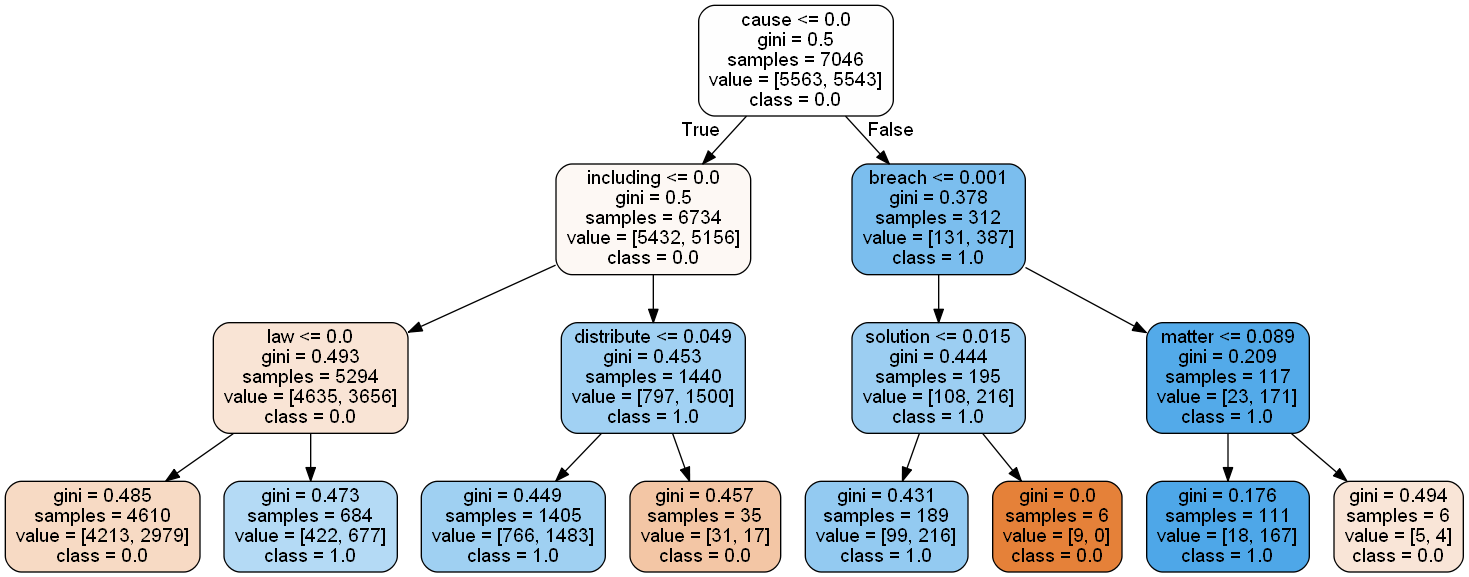

In [44]:
#Pick a tree in the forest and plot
set_tree_number=8
graphs,tree_plot = plot_tree(tree_number=set_tree_number,plot_name=valid_path+'tree.dot')
Image(tree_plot)

#### Plot Tree
<a id='Plot tree'></a>
Here, we plot one single decision tree from the simplified forest. A decision tree would create sequential questions/conditions and then it partitions the data into smaller groups based on that. Once the partition is complete a predictive decision is made at the terminal node (last layer of the tree). 

For each of the nodes (except the leaf nodes), the five rows represent:

1. Condition of features asked about the data input: At each internal node, if the observation matches the condition, then travel down the left branch. If the observation does not match the condition, then travel down the right branch.
2. gini: the Gini Impurity of the node. Gini Impurity is the probability of misclassifying an observation among all samples in the node. This is how decision tree makes splits. The average (weighted by samples) gini impurity decreases with each level of the tree. 
    
3. samples: number of training instances in the node
4. value: [number of samples in the first class (Acceptable), number of samples in the second class(Unacceptable)]
5. class: the class predicted for all the points in the node if the tree ended at this depth.
The leaf nodes (the terminal nodes at each branch) do not have a question because they are where the tree makes a prediction. All of the samples in a leaf node are assigned the same class.

```Note: Since we oversimplied the model in order to show the tree as a example, gini impurity measure is large at the terminal node. It is not the actual tree in the forest we use in practice.```

Imagine the tree above has been extended to a tree with 2000 layers and there are 1000 trees in the forest. That is the one we use for the EULA challenge. With more node, the decision paths are complex and hard to plot in small size.

________________

#### Validation Prediction Results and Explanation
<a id='Validation Prediction Results and Explanation'></a>

In [24]:
validation_df.head()

,Clause ID,Clause Text,Prediction,Probability Acceptable
0,94,\tthe Customer does not make any admissions (s...,0,62.0
1,7028,Requests. Company will notify Customer before ...,1,43.4
2,9048,We sometimes release beta versions of our webs...,0,55.7
3,7755,Termination without Cause. Customer may termin...,1,28.7
4,1145,1.8 “Term” means the term of this Agreement as...,0,93.3


The dataframe shown above is the prediction results from the actual random forest model that we use. The decision path for each tree in the forest are similar to the tree plot but in a more complicated way, since there are total thousands of layers containing tons of questions for each tree. Every instance in the validation data would be vectorized and split based on gini impurity measure through the tree. \
After all trees in the forest have prediction results, the final result would be generated based on majority 'voting'. \
The Probability Acceptable returns the number of votes for each class, divided by the number of trees in the forest. 


Let's take one example and explicitly figure out how the prediction is made. 
Here we take one clause with Clause ID of 1519. Among trees in the forest, pick the same tree as shown before to get the prediction.

In [41]:
test_df = validation_df[validation_df['Clause ID']==1519].reset_index(drop=True)
test_df

,Clause ID,Clause Text,Prediction,Probability Acceptable
0,1519,16. General. This Agreement constitutes the ...,1,43.1


In [45]:
sample_X_test_df = nlp.nlp_cleaning_pre(test_df, colname='PRE_CLEAN_TEXT', textcol='Clause Text')
sample_X_test = save_vectorizer.transform(sample_X_test_df['PRE_CLEAN_TEXT']).toarray()
print(f'The prediction for this example is {sbest_model.estimators_[set_tree_number].predict(sample_X_test)},\
and the Probability Acceptable is {round(sbest_model.estimators_[set_tree_number].predict_proba(sample_X_test)[0][0],2)}')

Updated NLP!
The prediction for this example is [1.],and the Probability Acceptable is 0.34


**Please note**: here we use the same simplified decision tree, as the tree plot shown above to predict. 
Therefore, the probablity of accpetance is ```not exactly``` the same as the dataframe showed in the previous cell.


Let's take a look at the decision path:
1. Output the important features that the tree used to split nodes
2. Plot the decision path of the tree. Colored nodes means this example would pass through it and reach its prediction.
3. Use the output from 1. and follow the tree path from 2. you can get how the single tree decides the prediction.

In [34]:
#Create the dataframe to save important features ; more details would be explained later
sfeats = {} # a dict to hold feature_name: feature_importance
for sfeature, simportance in zip(save_vectorizer.get_feature_names(), sbest_model.feature_importances_):
    sfeats[sfeature] = simportance #add the name/value pair 
simportances = pd.DataFrame.from_dict(sfeats, orient='index').rename(columns={0: 'Gini-importance'})
simportances = simportances.sort_values(by='Gini-importance',ascending= False)
simportances = simportances.reset_index().rename(columns={'index':'Feature name'})


In [46]:
def extract_node_word(graphtoplot=graphs,node_number=sclf_model.estimators_[set_tree_number].tree_.node_count):
    '''
    This function is to extract the words that contain the condition to split nodes
    node_number: total node number can be generated from clf(random forest).estimators_[tree_number].tree_.node_count
    '''
    node_list = []
    for i in range(0,node_number):
        try:
            
            node_name = graphtoplot.get_node(str(i))[0].get_attributes()['label']
            if '<=' in node_name:
                node_name = node_name.split('<=')[0].strip(' |""')
                #print(i,node_name)
                node_list.append(node_name)
            else:
                pass
        except:
            pass
        
    return node_list

node_list = extract_node_word()
print(node_list)
node_words = pd.DataFrame()

for word in node_list:
    # output relavant words that the tree used
    node_words = pd.concat([node_words,simportances[simportances['Feature name']==word]],axis=0)
node_words

['cause', 'including', 'law', 'distribute', 'breach', 'solution', 'matter']


,Feature name,Gini-importance
36,cause,0.013181
5,including,0.031904
30,law,0.015313
63,distribute,0.001727
3,breach,0.036743
67,solution,0.001623
76,matter,0.000711


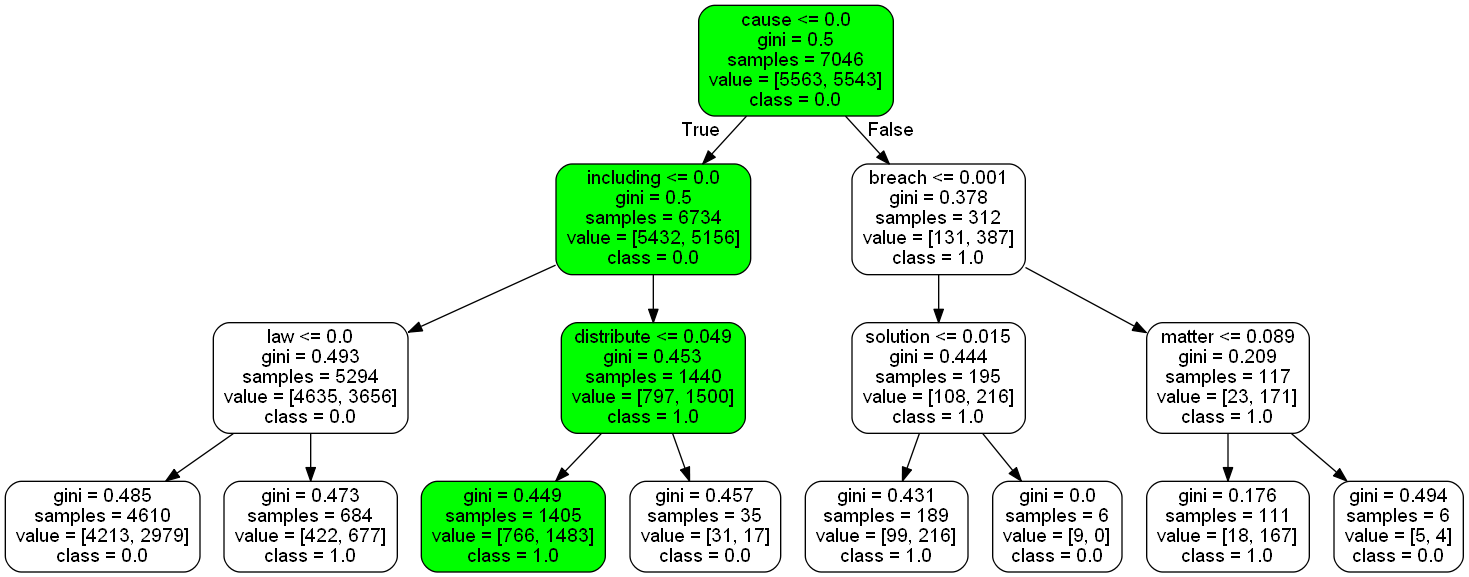

In [47]:

plot_name=valid_path+'simpletree.dot'
dot_data = export_graphviz(sbest_model.estimators_[set_tree_number], plot_name, rounded = True, 
    feature_names = save_vectorizer.get_feature_names(), 
    class_names = ['0.0', '1.0'], filled = True)
(graphs,) = pydot.graph_from_dot_file(plot_name)


# empty all nodes, i.e.set color to white and number of samples to zero
for node in graphs.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')


decision_paths = sclf_model.estimators_[set_tree_number].decision_path(sample_X_test)
decision_paths


for decision_path in decision_paths:
#    print(decision_path)
#    print(type(decision_path))
    #print(decision_path.toarray()[0])
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        
        node = graphs.get_node(str(n))[0]   
        
        node.set_fillcolor('green')
        
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

        node.set('label', '<br/>'.join(labels))

filename = plot_name.replace('.dot','.png')

graphs.write_png(filename)
Image(filename)

The logic of single tree is explained. Again, the Random Forest model that we use in practice is a tree-based method, but with more nodes and splits as shown in the next cell.

In [19]:
print(f'Random Forest has {clf_model.n_estimators} nodes with maximum depth {clf_model.max_depth}.')

Random Forest has 1000 nodes with maximum depth 2000.
